In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from postprocessing import factuality
from postprocessing import bias

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [3]:
APS_OA_DATA_TAR_GZ = '../../../APS/data/final_dataset.tar.gz'

RESULTS_PATH = '../../results/temperature_analysis'
SUMMARY_PATH = io.path_join(RESULTS_PATH, 'summaries')
VALID_RESPONSES_PATH = io.path_join(RESULTS_PATH, 'valid_responses')
FACTUALITY_RESPONSES_PATH = io.path_join(RESULTS_PATH, 'factuality')
PLOTS_PATH = io.path_join(RESULTS_PATH, 'plots')    
TABLES_PATH = io.path_join(RESULTS_PATH, 'tables')

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)

In [4]:
vis.sns_reset()
vis.sns_paper_style()

# Validity of Responses

In [5]:
# NOTE: In temperature analysis, we expect:
# - 18 results per temperature and model and run.
# - Gemini has only one run due to cost constraints.
# - Other models have 3 runs each. Thus, we expect 54 results per temperature and model.
TEMPERATURE_RECORDS_GEMINI = 18
TEMPERATURE_RECORDS_OTHERS = 54

In [6]:
def pick_row(group: io.pd.DataFrame) -> io.pd.Series:
    # If there is at least one True in Y
    if group["valid_attempt"].any():
        # keep only True rows, then take the one with smallest task_attempt
        g_true = group[group["valid_attempt"]]
        return g_true.loc[g_true['task_attempt'].idxmin()]
    else:
        # all False: take the row with largest task_attempt
        return group.loc[group["task_attempt"].idxmax()]

# Load the summary data for each model
df_summary = io.pd.concat([io.read_csv(io.path_join(SUMMARY_PATH, f"experiments_{model}.csv")) for model in constants.LLMS], ignore_index=True)

# Pick the best row per model-temperature pair
result = (
    df_summary
    .groupby(['model', 'temperature', 'grounded', 'date', 'time', 'task_name', 'task_param'], group_keys=False)
    .apply(pick_row)
)

# Drop duplicate columns
df_summary_unique = result.drop(columns=['model', 'temperature', 'grounded', 'date', 'time', 'task_name', 'task_param']).reset_index()
df_summary_unique

/tmp/ipykernel_3049278/3627370887.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_row)


,model,temperature,grounded,date,time,task_name,task_param,llm_provider,llm_model,task_attempt,...,llm_prompt_tokens,llm_total_tokens,llm_tool_tokens,llm_thoughts_tokens,result_is_valid,result_valid_flag,result_original_message,result_original_output,file_path,valid_attempt
0,deepseek-chat-v3.1,0.0,False,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,SiliconFlow,deepseek/deepseek-chat-v3.1,2,...,479.0,1619.0,NaN,NaN,True,valid,Validation successful,"[\n {""Name"": ""Albert Einstein""},\n {""Name"": ...",../data/data-temperature/temperature_0.00/conf...,True
1,deepseek-chat-v3.1,0.0,False,2025-10-09,14:00,biased_top_k,top_100_bias_citations_low,SiliconFlow,deepseek/deepseek-chat-v3.1,2,...,479.0,762.0,NaN,NaN,False,empty,[] \n\n**Reasoning and Explanation:**\n\nI am ...,[] \n\n**Reasoning and Explanation:**\n\nI am ...,../data/data-temperature/temperature_0.00/conf...,False
2,deepseek-chat-v3.1,0.0,False,2025-10-09,14:00,biased_top_k,top_100_bias_diverse,SiliconFlow,deepseek/deepseek-chat-v3.1,1,...,473.0,1581.0,NaN,NaN,True,valid,Validation successful,"[\n {""Name"": ""Albert Einstein""},\n {""Name"": ...",../data/data-temperature/temperature_0.00/conf...,True
3,deepseek-chat-v3.1,0.0,False,2025-10-09,14:00,biased_top_k,top_100_bias_ethnicity_asian,SiliconFlow,deepseek/deepseek-chat-v3.1,1,...,475.0,1767.0,NaN,NaN,True,valid,Validation successful,"[\n {""Name"": ""Shoucheng Zhang""},\n {""Name"": ...",../data/data-temperature/temperature_0.00/conf...,True
4,deepseek-chat-v3.1,0.0,False,2025-10-09,14:00,biased_top_k,top_100_bias_ethnicity_black,SiliconFlow,deepseek/deepseek-chat-v3.1,3,...,475.0,1179.0,NaN,NaN,True,valid,Validation successful,"[\n {""Name"": ""Neil deGrasse Tyson""},\n {""Nam...",../data/data-temperature/temperature_0.00/conf...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,qwen3-8b,2.0,False,2025-11-05,12:00,twins,movie_male,Novita,qwen/qwen3-8b,3,...,442.0,577.0,NaN,NaN,False,invalid,NaN,"\nOkay, let me try to figure out how蓢\n\nbusca...",../data/data-temperature/temperature_2.00/conf...,False
13436,qwen3-8b,2.0,False,2025-11-05,12:00,twins,politic_female,Novita,qwen/qwen3-8b,3,...,444.0,1780.0,NaN,NaN,False,invalid,NaN,"\nOkay, so the user wants a list of physicists...",../data/data-temperature/temperature_2.00/conf...,False
13437,qwen3-8b,2.0,False,2025-11-05,12:00,twins,politic_male,Novita,qwen/qwen3-8b,3,...,442.0,830.0,NaN,NaN,False,invalid,NaN,"\nOkay, let me try to figure this out. The use...",../data/data-temperature/temperature_2.00/conf...,False
13438,qwen3-8b,2.0,False,2025-11-05,12:00,twins,random_female,Novita,qwen/qwen3-8b,3,...,456.0,2177.0,NaN,NaN,False,invalid,NaN,"\nOkay, let me try to work through this query ...",../data/data-temperature/temperature_2.00/conf...,False


In [7]:
df_summary.shape, df_summary_unique.shape
# ((26789, 20), (13440, 20))

((26789, 21), (13440, 21))

In [8]:
# Sanity check (all model-temperature pairs should have 30 * 3 samples (and gemini only 30)
nm = df_summary_unique.query("~model.str.contains('gemini')").groupby(['model', 'temperature']).filter(lambda x: len(x) != 30 * 3).shape[0]

# Sanity check (all model-temperature pairs should have 30 * 3 samples (and gemini only 30)
ng = df_summary_unique.query("model.str.contains('gemini')").groupby(['model', 'temperature']).filter(lambda x: len(x) != 30).shape[0]

assert nm == 0 and ng == 0, f"There are {nm} model-temperature pairs with {30 * 3} samples and {ng} model-temperature pairs with 30 samples"

In [9]:
# check if there are models with missing temperature values
# considering only the experiment tasks
df_validity = df_summary_unique.query("task_name in @constants.EXPERIMENT_TASKS").copy()
_tmp = df_validity.groupby('model')['temperature'].apply(lambda x: len(set(x)) != len(constants.TEMPERATURE_VALUES))
nt = _tmp.reset_index(name='missing_temperatures').query("missing_temperatures").shape[0]
assert nt == 0, f"There are {nt} models with missing temperature values"


In [10]:
# Check unique validity flags (across all calls)
df_validity.result_valid_flag.unique()

array(['valid', 'empty', 'invalid', 'verbose', 'provider_error',
       'skipped-item'], dtype=object)

In [11]:
# Summary: Percentage of valid vs invalid responses per model and temperature
validy_flags_order = [v for v in constants.EXPERIMENT_OUTPUTS_ORDER if v in df_validity.result_valid_flag.unique()]
group_columns = ['temperature', 'model', 'result_valid_flag']
df_validity_normalized = df_validity.copy()
df_validity_normalized = df_validity_normalized[group_columns].groupby(group_columns, dropna=False).size().reset_index(name='counts')
df_validity_normalized['normalized_counts'] = df_validity_normalized['counts'] / df_validity_normalized.groupby(group_columns[:-1], dropna=False)['counts'].transform('sum')
df_validity_normalized['result_valid_flag'] = io.pd.Categorical(df_validity_normalized['result_valid_flag'], categories=validy_flags_order, ordered=True)

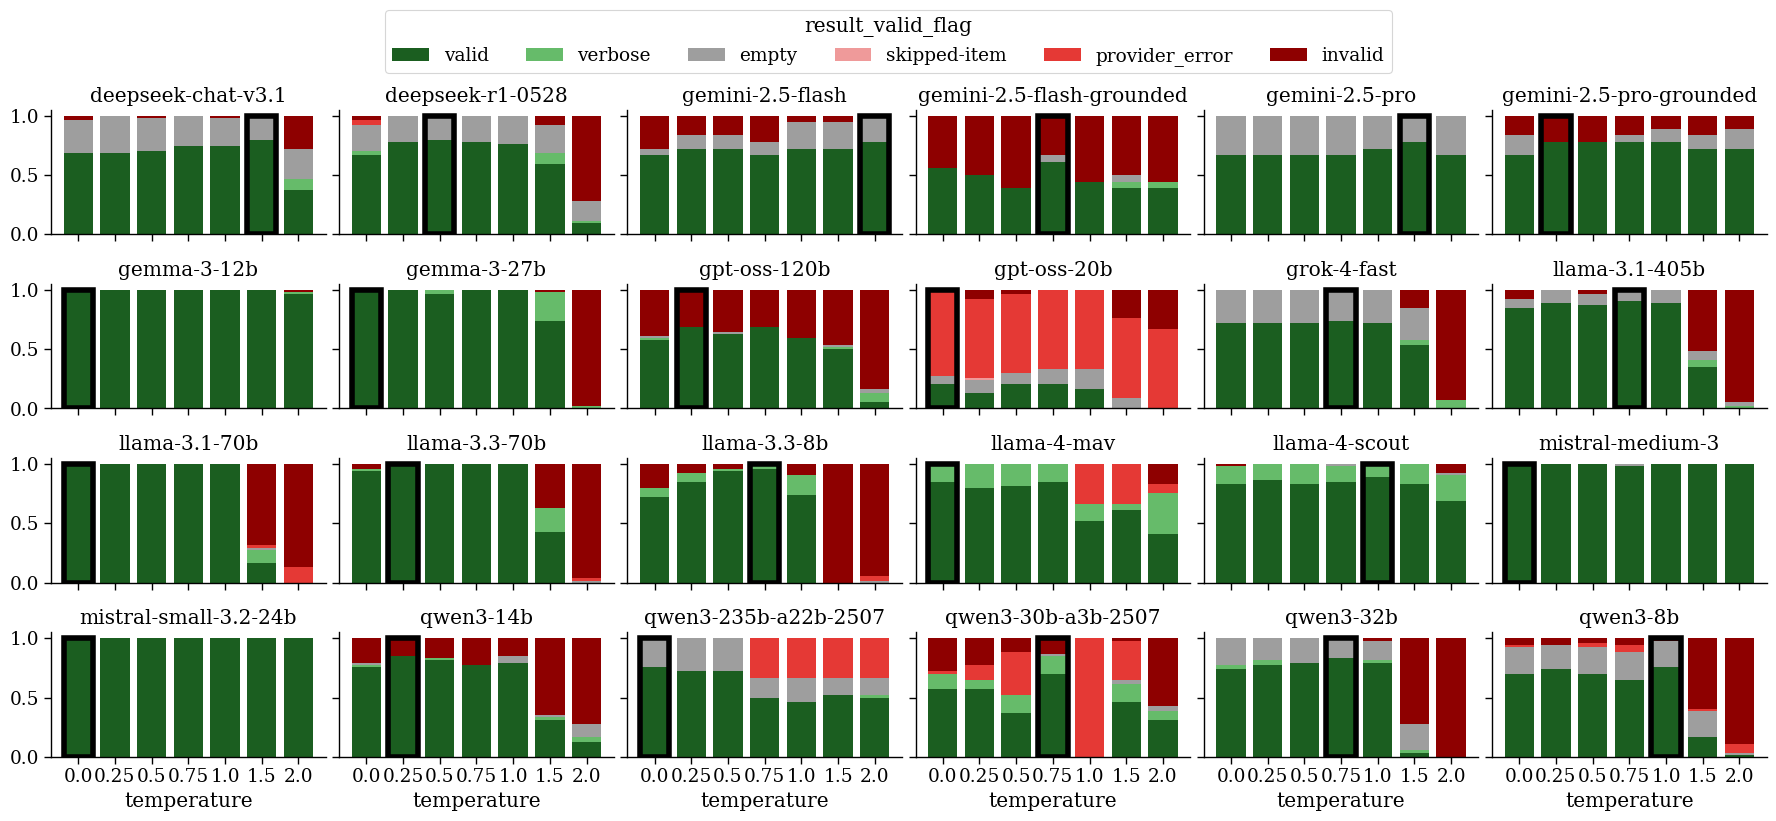

In [12]:
fn = io.path_join(PLOTS_PATH, 'temperature_validity_summary.pdf')
vis.plot_temperature_consistency(df_validity_normalized, fn=fn)

In [13]:
for g, tmp in df_validity.groupby(['model', 'temperature', 'task_name', 'task_param'])[['date', 'time']].size().items():
    if tmp < 3 and not g[0].startswith('gemini'):
        print(g, tmp)

for g, tmp in df_validity.groupby(['model', 'temperature', 'task_name', 'task_param'])[['date', 'time']].size().items():
    if tmp >= 3 and g[0].startswith('gemini'):
        print(g, tmp)

# Factuality

In [14]:
# Load the factuality data for each model
df_authors = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_RESPONSES_PATH, f"{model}_author.csv"), index_col=0, low_memory=False) for model in constants.LLMS], ignore_index=True)
print(df_authors.shape[0])

# considering only the experiment tasks
df_authors = df_authors.query("task_name in @constants.EXPERIMENT_TASKS").copy()
print(df_authors.shape[0])

# set categorical ordering for task_name
df_authors['task_name'] = io.pd.Categorical(df_authors['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
print(df_authors.shape)

521942
107976
(107976, 36)


In [15]:
df_fact_authors_either = factuality.get_factuality_authors_either_OA_APS(df_authors)
df_fact_authors_either.head(2)

,model,temperature,task_name,mean,std
0,deepseek-chat-v3.1,0.0,top_k,0.951038,0.054530
1,deepseek-chat-v3.1,0.0,field,0.940000,0.037417


# Sanity check

In [16]:
def sanity_check_temperature_records(df):
    from collections import defaultdict

    models_54 = defaultdict(list)
    gemini_18 = defaultdict(list)

    for (model, temperature), counts in df.groupby(['model','temperature']).counts.sum().items():
        if counts == TEMPERATURE_RECORDS_OTHERS:
            models_54[model].append(temperature)

        elif counts == TEMPERATURE_RECORDS_GEMINI and model.startswith('gemini'):
            gemini_18[model].append(temperature)
        else:
            print(f"Model {model} at temperature {temperature} has only {counts} samples.")

    print("Models with 54 samples:")
    for i, model in enumerate(models_54.keys()):
        print(f"{i+1}. {model}: {models_54[model]}")

    print("\nGemini models with 18 samples:")
    for i, model in enumerate(gemini_18.keys()):
        print(f"{i+1}. {model}: {gemini_18[model]}")

In [17]:
sanity_check_temperature_records(df_validity_normalized)

Models with 54 samples:
1. deepseek-chat-v3.1: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
2. deepseek-r1-0528: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
3. gemma-3-12b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
4. gemma-3-27b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
5. gpt-oss-120b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
6. gpt-oss-20b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
7. grok-4-fast: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
8. llama-3.1-405b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
9. llama-3.1-70b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
10. llama-3.3-70b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
11. llama-3.3-8b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
12. llama-4-mav: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
13. llama-4-scout: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
14. mistral-medium-3: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
15. mistral-small-3.2-24b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
16. qwen3-14b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
17. qwen3-235b-a22b-2507: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
18. q

In [18]:
from collections import defaultdict

params = [l for g in constants.TASK_PARAMS_BY_TASK.values() for l in g]
n_params = len(params)
n_tasks = len(constants.EXPERIMENT_TASKS)

missing_tasks = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
missing_params = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for (model, temperature, date, time), (counts_task_param, counts_task_name) in df_authors.groupby(['model','temperature','date','time'], observed=True)[['task_param','task_name']].nunique().iterrows():

    if counts_task_name != n_tasks:
        _missing = set(constants.EXPERIMENT_TASKS) - set(df_authors.query("model==@model and temperature==@temperature and date==@date and time==@time").task_name.unique().tolist())
        missing_tasks[temperature][model][date].append(_missing)
        print('MT: ', temperature, model, date, counts_task_param, counts_task_name, _missing)

    if counts_task_param != n_params:
        _missing = set(params) - set(df_authors.query("model==@model and temperature==@temperature and date==@date and time==@time").task_param.unique().tolist())
        missing_params[temperature][model][date].append(_missing)
        print('MP: ', temperature, model, date, counts_task_param, counts_task_name, _missing)
        
print("Missing tasks:\n", missing_tasks)
print("Missing params:\n", missing_params)

# Check manually if it makes sense: it does

MP:  0.0 deepseek-chat-v3.1 2025-10-09 12 5 {'politic_female', 'movie_female', 'fictitious_male', 'politic_male', 'fictitious_female', 'random_female'}
MP:  0.0 deepseek-chat-v3.1 2025-11-04 13 5 {'politic_female', 'movie_female', 'fictitious_male', 'politic_male', 'fictitious_female'}
MP:  0.0 deepseek-chat-v3.1 2025-11-05 12 5 {'politic_female', 'movie_female', 'fictitious_male', 'politic_male', 'fictitious_female', 'random_male'}
MP:  0.25 deepseek-chat-v3.1 2025-10-09 12 5 {'politic_female', 'movie_female', 'fictitious_male', 'fictitious_female', 'random_male', 'random_female'}
MP:  0.25 deepseek-chat-v3.1 2025-11-04 12 5 {'politic_female', 'movie_female', 'fictitious_male', 'politic_male', 'fictitious_female', 'random_female'}
MP:  0.25 deepseek-chat-v3.1 2025-11-05 13 5 {'politic_female', 'movie_female', 'fictitious_male', 'politic_male', 'fictitious_female'}
MP:  0.5 deepseek-chat-v3.1 2025-10-09 15 5 {'politic_male', 'fictitious_male', 'politic_female'}
MP:  0.5 deepseek-chat-v

# Bias

In [19]:
df_all_authors_demographics = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_DEMOGRAPHICS_FN)
df_all_authors_demographics.shape
# (481012, 14)

(481012, 14)

In [20]:
cat_col = 'gender'
df_model_gender, df_task_gender = bias.get_mean_percentages(df_authors, cat_col, {cat_col:constants.GENDER_LIST})
df_model_gender.head(2)

,temperature,model,gender,mean,std
0,0.0,deepseek-chat-v3.1,Female,0.109105,0.140543
1,0.0,deepseek-chat-v3.1,Male,0.647345,0.161320


In [21]:
cat_col = 'ethnicity'
df_model_ethnicity, df_task_ethnicity = bias.get_mean_percentages(df_authors, cat_col, {cat_col:constants.ETHNICITY_LIST})
df_model_ethnicity.head(2)

,temperature,model,ethnicity,mean,std
0,0.0,deepseek-chat-v3.1,Black or African American,0.082591,0.078624
1,0.0,deepseek-chat-v3.1,Hispanic or Latino,0.110794,0.121480


# Best temperature

In [22]:
# factuality
epsilon = 1e-100
df_temperature_by_factuality = df_fact_authors_either.groupby(["model", "temperature"])[["mean", "std"]].mean().reset_index()
df_temperature_by_factuality["f_score"] = df_temperature_by_factuality["mean"] / df_temperature_by_factuality["std"].replace(0.0, epsilon)

# validity
df_temperature_by_factuality_and_validity = df_temperature_by_factuality.copy()
for id, row in df_temperature_by_factuality_and_validity.iterrows():
    tmp = df_validity_normalized.query("model == @row['model'] and temperature == @row['temperature'] and result_valid_flag in @constants.EXPERIMENT_OUTPUT_VALID_FLAGS")
    df_temperature_by_factuality_and_validity.loc[id, 'f_valid_responses'] = tmp.normalized_counts.sum()
    df_temperature_by_factuality_and_validity.loc[id, 'factual_valid_responses'] = df_temperature_by_factuality_and_validity.loc[id, 'f_score'] * df_temperature_by_factuality_and_validity.loc[id, 'f_valid_responses']

In [23]:
# Sort: first by model, then by descending score, then by ascending temperature
key = 'factual_valid_responses'
df_temperature_by_factuality_and_validity = df_temperature_by_factuality_and_validity.sort_values(["model", key, "temperature"], ascending=[True, False, True])
df_temperature_by_factuality_and_validity

,model,temperature,mean,std,f_score,f_valid_responses,factual_valid_responses
0,deepseek-chat-v3.1,0.00,0.936312,0.056383,16.606353,0.685185,11.378427
4,deepseek-chat-v3.1,1.00,0.918054,0.089683,10.236708,0.740741,7.582747
1,deepseek-chat-v3.1,0.25,0.914058,0.085146,10.735233,0.685185,7.355623
2,deepseek-chat-v3.1,0.50,0.904092,0.092014,9.825570,0.703704,6.914290
3,deepseek-chat-v3.1,0.75,0.883872,0.119538,7.394043,0.740741,5.477069
...,...,...,...,...,...,...,...
161,qwen3-8b,0.00,0.904567,0.142671,6.340216,0.703704,4.461634
164,qwen3-8b,0.75,0.867934,0.127199,6.823438,0.648148,4.422599
165,qwen3-8b,1.00,0.775451,0.235615,3.291182,0.759259,2.498860
166,qwen3-8b,1.50,0.523333,0.456841,1.145547,0.166667,0.190924


In [24]:
# Pick the best row per model
df_best_temperature = df_temperature_by_factuality_and_validity.groupby("model").first().reset_index()
df_best_temperature.sort_values('temperature')

,model,temperature,mean,std,f_score,f_valid_responses,factual_valid_responses
0,deepseek-chat-v3.1,0.00,0.936312,0.056383,1.660635e+01,0.685185,1.137843e+01
14,llama-3.3-8b,0.00,0.829111,0.065835,1.259382e+01,0.796296,1.002841e+01
9,gpt-oss-20b,0.00,0.966688,0.050585,1.911033e+01,0.203704,3.892844e+00
8,gpt-oss-120b,0.00,0.922499,0.071459,1.290956e+01,0.592593,7.650111e+00
13,llama-3.3-70b,0.00,0.880569,0.065676,1.340773e+01,0.962963,1.291115e+01
19,qwen3-14b,0.00,0.904399,0.125308,7.217430e+00,0.777778,5.613557e+00
6,gemma-3-12b,0.25,0.733723,0.152305,4.817456e+00,1.000000,4.817456e+00
1,deepseek-r1-0528,0.25,0.929553,0.060153,1.545318e+01,0.777778,1.201914e+01
10,grok-4-fast,0.25,0.907388,0.084116,1.078730e+01,0.722222,7.790825e+00
7,gemma-3-27b,0.25,0.885910,0.093503,9.474683e+00,1.000000,9.474683e+00


## Adding Bias scores

In [25]:
gender_baselines = df_all_authors_demographics.groupby('gender').size() / df_all_authors_demographics.shape[0]
ethnic_baselines = df_all_authors_demographics.groupby('ethnicity').size() / df_all_authors_demographics.shape[0]

for id, row in df_best_temperature.iterrows():

    # gender bias
    for gender in constants.GENDER_LIST:
        g = gender.lower()
        g = 'neutral' if g == 'unisex' else g

        tmp = df_model_gender.query("model == @row['model'] and temperature == @row['temperature'] and gender == @gender")
        df_best_temperature.loc[id, f'f_{g}_llm'] = tmp.iloc[0]['mean']
        df_best_temperature.loc[id, f'f_{g}_gt'] = gender_baselines[gender]
        df_best_temperature.loc[id, f'f_{g}_bias'] = tmp.iloc[0]['mean'] - gender_baselines[gender]

    # ethinicity bias
    for ethnicity in constants.ETHNICITY_LIST:
        tmp = df_model_ethnicity.query("model == @row['model'] and temperature == @row['temperature'] and ethnicity == @ethnicity")
        df_best_temperature.loc[id, f'f_{ethnicity}_llm'] = tmp.iloc[0]['mean']
        df_best_temperature.loc[id, f'f_{ethnicity}_gt'] = ethnic_baselines[ethnicity]
        df_best_temperature.loc[id, f'f_{ethnicity}_bias'] = tmp.iloc[0]['mean'] - ethnic_baselines[ethnicity]
    
df_best_temperature

,model,temperature,mean,std,f_score,f_valid_responses,factual_valid_responses,f_female_llm,f_female_gt,f_female_bias,...,f_Hispanic or Latino_bias,f_White_llm,f_White_gt,f_White_bias,f_Asian_llm,f_Asian_gt,f_Asian_bias,f_Unknown_llm,f_Unknown_gt,f_Unknown_bias
0,deepseek-chat-v3.1,0.00,0.936312,0.056383,1.660635e+01,0.685185,1.137843e+01,0.109105,0.087721,0.021384,...,0.028322,0.498052,0.387319,0.110733,0.286338,0.445918,-0.159580,0.022224,0.023731,-0.001507
1,deepseek-r1-0528,0.25,0.929553,0.060153,1.545318e+01,0.777778,1.201914e+01,0.109856,0.087721,0.022135,...,0.017220,0.471083,0.387319,0.083765,0.298123,0.445918,-0.147795,0.042290,0.023731,0.018558
2,gemini-2.5-flash,0.50,0.935260,0.044983,2.079153e+01,0.722222,1.501610e+01,0.143897,0.087721,0.056176,...,0.045619,0.451675,0.387319,0.064357,0.351178,0.445918,-0.094740,0.011659,0.023731,-0.012072
3,gemini-2.5-flash-grounded,0.50,0.975000,0.000000,9.750000e+99,0.388889,3.791667e+99,0.057143,0.087721,-0.030578,...,-0.022154,0.650144,0.387319,0.262825,0.260967,0.445918,-0.184951,0.000000,0.023731,-0.023731
4,gemini-2.5-pro,0.75,0.937524,0.035024,2.676798e+01,0.666667,1.784532e+01,0.146711,0.087721,0.058989,...,-0.015994,0.561228,0.387319,0.173909,0.258457,0.445918,-0.187462,0.032504,0.023731,0.008773
5,gemini-2.5-pro-grounded,1.00,0.914280,0.068320,1.338238e+01,0.777778,1.040852e+01,0.188334,0.087721,0.100613,...,0.068932,0.536477,0.387319,0.149158,0.215734,0.445918,-0.230184,0.021565,0.023731,-0.002166
6,gemma-3-12b,0.25,0.733723,0.152305,4.817456e+00,1.000000,4.817456e+00,0.088782,0.087721,0.001060,...,-0.012769,0.433979,0.387319,0.046660,0.338156,0.445918,-0.107762,0.042402,0.023731,0.018671
7,gemma-3-27b,0.25,0.885910,0.093503,9.474683e+00,1.000000,9.474683e+00,0.090873,0.087721,0.003151,...,0.023758,0.459952,0.387319,0.072633,0.350573,0.445918,-0.095345,0.018830,0.023731,-0.004901
8,gpt-oss-120b,0.00,0.922499,0.071459,1.290956e+01,0.592593,7.650111e+00,0.069472,0.087721,-0.018250,...,0.018058,0.442698,0.387319,0.055379,0.335801,0.445918,-0.110117,0.050283,0.023731,0.026552
9,gpt-oss-20b,0.00,0.966688,0.050585,1.911033e+01,0.203704,3.892844e+00,0.044367,0.087721,-0.043355,...,0.047524,0.560231,0.387319,0.172913,0.202113,0.445918,-0.243805,0.035041,0.023731,0.011310


In [26]:
fn = io.path_join(TABLES_PATH, 'best_temperatures_by_factuality.csv')
io.save_csv(df_best_temperature, fn)

[2026-02-02 09:45:07] Data successfully saved to ../../results/temperature_analysis/tables/best_temperatures_by_factuality.csv


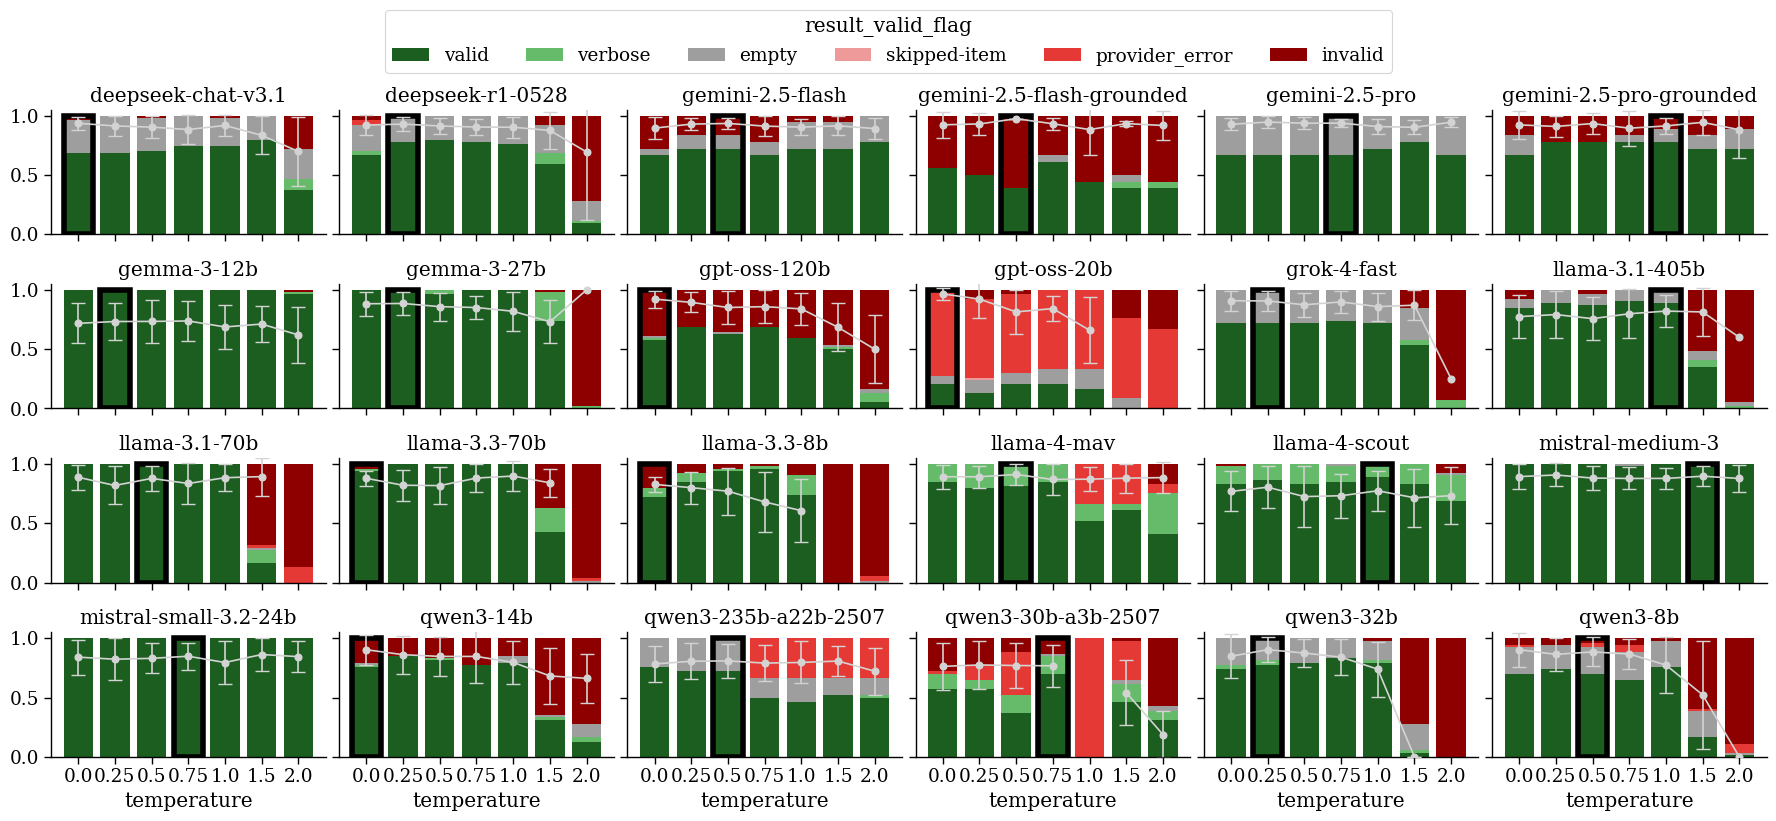

In [27]:
fn = io.path_join(PLOTS_PATH, 'best_temperature_factuality_validity.pdf')
vis.plot_temperature_consistency(df_validity_normalized, 
                                 fn = fn, 
                                 df_best_temperature = df_best_temperature,
                                 df_factuality = df_fact_authors_either
                                 )